In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

### 1. data preprorcessing: prepare data for training & test sets

#### import dataset and data cleaning and selection 

The training dataset includes wind speeds of various altitude increments, in 10 minutes intervals, for a little more than 12 month. It includes horizontal wind speed, vertical wind speed, mean values, max and min values in the increments, standard deviations and other columns. 

There are certain unrealistic values for wind speeds suh as 9999 or 9998 or N/A, this is likely due to processing error in the technical instrumet.

Thus, for data cleaning, we will filter out the values above 50 as it is nearly impossible for wind speed in the given altitudes to exceed 50. And for data selection, we shall only use the columns that record the horizontal wind speeds as the HAWTs (Horizontal-Axis Wind Turbines) use the lift force of the horizontal winds to generate energy, and disregard the other data for now.  

In [4]:
file_path = "../Data/E05_Hudson_South_West_10_min_avg_20220129_20230128.xls"

data = pd.read_excel(file_path)

data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract month, day, hour, and minute from the timestamp
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['hour'] = data['timestamp'].dt.hour
data['minute'] = data['timestamp'].dt.minute

# Sort the DataFrame by month, day, hour, and minute
data = data.sort_values(by=['month', 'day', 'hour', 'minute'])

data.drop(['month', 'day', 'hour', 'minute'], axis=1, inplace=True)

# Reset the index after sorting (optional, but often useful)
data = data.reset_index(drop=True)

data.head()

,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2023-01-01 00:00:00,7.3269,0.345,8.143,6.6933,221.7009,9998,36,0,27,...,4.995,-5.076,7.099,-6.121,2.986,-3.229,12.93,39.4851,-73.591,E05
1,2023-01-01 00:10:00,6.3896,0.3397,6.9518,5.7575,217.042,9998,36,0,31,...,4.152,-6.412,5.209,-6.512,2.5,-2.765,12.93,39.4851,-73.591,E05
2,2023-01-01 00:20:00,7.1015,0.3568,8.1623,6.5591,209.9876,9998,36,0,28,...,5.764,-6.225,5.8,-6.486,2.47,-4.338,12.93,39.4852,-73.591,E05
3,2023-01-01 00:30:00,5.9553,0.8678,7.1101,3.1298,205.8061,9998,36,0,23,...,4.465,-5.433,7.881,-5.817,2.532,-2.711,12.93,39.4851,-73.591,E05
4,2023-01-01 00:40:00,6.7674,0.7662,7.9653,5.2171,198.5833,9998,36,0,21,...,4.05,-5.951,6.942,-6.305,3.564,-3.775,12.93,39.4851,-73.591,E05


In [5]:
file_path = "../Data/E05_Hudson_North_10_min_avg_20190812_20210919.csv"

data = pd.read_csv(file_path)

## Correcting the column name for timestamp and sorting the data
#data['timestamp'] = pd.to_datetime(data['timestamp'])
#
## Extract month, day, hour, and minute
#data['month'] = data['timestamp'].dt.month
#data['day'] = data['timestamp'].dt.day
#data['hour'] = data['timestamp'].dt.hour
#data['minute'] = data['timestamp'].dt.minute
#data['year'] = data['timestamp'].dt.year
#
## Sort the DataFrame by month, day, hour, and minute (ignoring the year)
#sorted_data = data.sort_values(by=['month', 'day', 'year', 'hour', 'minute'])

data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

sorted_data = data[data['timestamp'] <= pd.Timestamp('2021-08-11')]

sorted_data.head()  # Display the first few rows of the sorted DataFrame

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_15628\2085073276.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,52,53,54,55,56,57,58,59,60,62,63,64,65,66,67,68,69,70,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,89,90,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2019-08-12 00:00:00,7.2923,0.5159,8.2792,6.0537,251.5426,0.1971,4.0,0.0,36.0,...,7.644,-6.274,6.088,-7.194,6.121,-6.098,13.03,39.9695,-72.716,E05
1,2019-08-12 00:10:00,7.8613,0.6321,9.1869,6.1966,245.2114,0.1425,4.0,0.0,37.0,...,7.205,-6.716,6.86,-8.25,6.024,-5.765,13.03,39.9694,-72.716,E05
2,2019-08-12 00:20:00,7.7594,0.635,9.0702,6.1366,246.7355,0.1568,4.0,0.0,37.0,...,6.416,-7.058,5.03,-7.563,5.344,-6.38,13.03,39.9695,-72.716,E05
3,2019-08-12 00:30:00,7.4891,0.4983,8.6377,6.5824,247.0218,0.0493,4.0,0.0,38.0,...,7.767,-7.505,5.555,-7.663,7.64,-8.3,13.03,39.9695,-72.716,E05
4,2019-08-12 00:40:00,7.8829,0.6361,9.4056,6.4107,244.106,0.0897,4.0,0.0,37.0,...,6.627,-6.468,7.694,-9.47,6.511,-7.137,13.02,39.9695,-72.716,E05


In [6]:
## Generate a full range of dates
#start_date = datetime(2019, 1, 1)
#end_date = datetime(2021, 12, 31)
#date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
#
## Reindex the data
#data.set_index('timestamp', inplace=True)
#data_reindexed = data.reindex(date_range)
#
## Find missing timestamps
#missing_timestamps = data_reindexed[data_reindexed.isna().all(axis=1)].index
#
## Extract only the dates from the missing timestamps
#missing_dates = missing_timestamps.date
#unique_missing_dates = pd.Series(missing_dates).unique()
#
## Print the unique missing dates
#for date in unique_missing_dates:
#    print(date)

In [7]:
# Filtering columns with 'HorizWS' in their names
horiz_ws_columns = [col for col in data.columns if 'lidar_lidar138m_Z10_HorizWS' in col]
horiz_ws_data = data[horiz_ws_columns]

# Converting wind speed columns to numeric, setting errors='coerce' to turn non-numeric values into NaN
numeric_horiz_ws_data = horiz_ws_data.apply(pd.to_numeric, errors='coerce')

# Filtering out all values above 50
cleaned_numeric_horiz_ws_data = numeric_horiz_ws_data[numeric_horiz_ws_data <= 50].dropna()

# Displaying the first few rows of the cleaned numeric data
cleaned_numeric_horiz_ws_data.head()

,lidar_lidar138m_Z10_HorizWS
0,7.8635
1,8.1698
2,8.1291
3,7.9652
4,8.0443


In [8]:
len(cleaned_numeric_horiz_ws_data)

100711

#### Data normalization

The data is normalized with MinMax (imported from the scikit-learn library) for MinMax scaling's ability to transform data into a bounded range while preserving temporal relationships. It is suitable for TimeGAN models like this one, which are designed to generate realistic time-series data.

In [9]:
# Initializing the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(cleaned_numeric_horiz_ws_data)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns=cleaned_numeric_horiz_ws_data.columns)

# Displaying the first few rows of the normalized data
normalized_df.head()

,lidar_lidar138m_Z10_HorizWS
0,0.244887
1,0.254954
2,0.253616
3,0.248229
4,0.250829


#### Reshaping the data

LSTM model is chosen to focus on seasonal variations so the previos

In [10]:
points_in_month = int(len(cleaned_numeric_horiz_ws_data) / (2 * 12))
points_in_month

4196

In [11]:
ratio = [1, 11]

In [12]:
input_sequence_length = points_in_month * ratio[0]
output_sequence_length = points_in_month * ratio[1]

In [13]:
#def create_sequences(data, history_length, forecast_length):
#    X, Y = [], []
#    for i in range(0, len(data) - history_length - forecast_length + 1, forecast_length):
#        X.append(data[i:(i + history_length)])
#        Y.append(data[(i + history_length):(i + history_length + forecast_length)])
#    return np.array(X), np.array(Y)

In [14]:
#X, Y = create_sequences(normalized_df, input_sequence_length, output_sequence_length)
#training_ratio = 0.5
#train_size = int(training_ratio * len(X))
#X_train, Y_train = X[:train_size], Y[:train_size]
#X_test, Y_test = X[train_size:], Y[train_size:]

In [15]:
def create_sequences(data, history_length, forecast_ratio):
    X, Y = [], []
    forecast_length = history_length * forecast_ratio
    for i in range(0, len(data) - history_length - forecast_length + 1, history_length + forecast_length):
        X.append(data[i:(i + history_length)])
        Y.append(data[(i + history_length):(i + history_length + forecast_length)])
    return np.array(X), np.array(Y)

# Assuming input_sequence_length is defined and forecast_ratio is set to 11
forecast_ratio = 11
X, Y = create_sequences(normalized_df, input_sequence_length, forecast_ratio)

# Splitting the data in half for training and testing
train_size = len(X) // 2
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [16]:
def create_sequences(data, history_length, forecast_ratio):
    X, Y = [], []
    forecast_length = history_length * forecast_ratio
    total_sequence_length = history_length + forecast_length

    # Check if the total sequence length is longer than the data length
    if total_sequence_length > len(data):
        print("Total sequence length is greater than the data length. Adjusting the lengths.")
        # Adjust the lengths to fit the data
        forecast_length = len(data) - history_length
        total_sequence_length = len(data)

    for i in range(0, len(data) - total_sequence_length + 1, total_sequence_length):
        X.append(data[i:(i + history_length)])
        Y.append(data[(i + history_length):(i + total_sequence_length)])
    return np.array(X), np.array(Y)

# Assuming input_sequence_length is defined
forecast_ratio = 11
X, Y = create_sequences(normalized_df, input_sequence_length, forecast_ratio)

# Splitting the data in half for training and testing
train_size = len(X) // 2
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (1, 4196, 1)
Y_train shape: (1, 46156, 1)
X_test shape: (1, 4196, 1)
Y_test shape: (1, 46156, 1)


#### Defining the LSTM model

In [17]:
n_neurons = 384
activation = "sigmoid"
num_epochs = 100
learning_rate = 0.0007091182246779932
minibatch_size = 64

In [18]:
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(input_sequence_length, 1), return_sequences=True, activation = activation))
model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(output_sequence_length))

# Model compilation
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 20, verbose = 1, restore_best_weights = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4196, 384)         592896    
                                                                 
 dropout (Dropout)           (None, 4196, 384)         0         
                                                                 
 lstm_1 (LSTM)               (None, 384)               1181184   
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense (Dense)               (None, 46156)             17770060  
                                                                 
Total params: 19544140 (74.55 MB)
Trainable params: 19544140 (74.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
history = model.fit(X_train, Y_train, epochs = num_epochs, batch_size = minibatch_size, validation_data=(X_test, Y_test), callbacks=[early_stop])

Epoch 1/100
1/1 [==============================] - 17s 17s/step - loss: 0.1379 - val_loss: 0.1169
Epoch 2/100
1/1 [==============================] - 14s 14s/step - loss: 0.1259 - val_loss: 0.0888
Epoch 3/100
1/1 [==============================] - 14s 14s/step - loss: 0.0931 - val_loss: 0.0502
Epoch 4/100
1/1 [==============================] - 14s 14s/step - loss: 0.0459 - val_loss: 0.0321
Epoch 5/100
1/1 [==============================] - 14s 14s/step - loss: 0.0110 - val_loss: 0.0545
Epoch 6/100
1/1 [==============================] - 14s 14s/step - loss: 0.0143 - val_loss: 0.0765
Epoch 7/100
1/1 [==============================] - 15s 15s/step - loss: 0.0216 - val_loss: 0.0772
Epoch 8/100
1/1 [==============================] - 14s 14s/step - loss: 0.0190 - val_loss: 0.0683
Epoch 9/100
1/1 [==============================] - 14s 14s/step - loss: 0.0072 - val_loss: 0.0617
Epoch 10/100
1/1 [==============================] - 14s 14s/step - loss: 0.0039 - val_loss: 0.0584
Epoch 11/100
1/1 [=

In [20]:
def make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

cwd = os.getcwd()
model_path = os.path.join(cwd, 'saved_model')
make_dir(model_path)
model.save(os.path.join(model_path, 'LSTM_model_new_1.h5'))

c:\Users\Jiarong Xie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
model_path = os.path.join(os.getcwd(), 'saved_model', 'LSTM_model_new_1.h5')
lstm_model = load_model(model_path)

In [22]:
test_mse = lstm_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test MSE: {test_mse}")

Test MSE: 0.03209139034152031


In [22]:
train_size = int(training_ratio * len(cleaned_numeric_horiz_ws_data))
Y_test = cleaned_numeric_horiz_ws_data[train_size:]
Y_test = Y_test[:len(X_test) * len(X_test[0])]

NameError: name 'training_ratio' is not defined

In [30]:
y_pred = lstm_model.predict(X_test)

1/1 [==============================] - 1s 938ms/step


In [32]:
y_pred = scaler.inverse_transform(y_pred)

num_samples, num_timesteps, num_features = Y_test.shape
Y_test_reshaped = Y_test.reshape(-1, num_features)  # Reshape to 2D
Y_test_inverse = scaler.inverse_transform(Y_test_reshaped)
Y_test_inverse_reshaped = Y_test_inverse.reshape(num_samples, num_timesteps, num_features)

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_15628\921873589.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_15628\921873589.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637

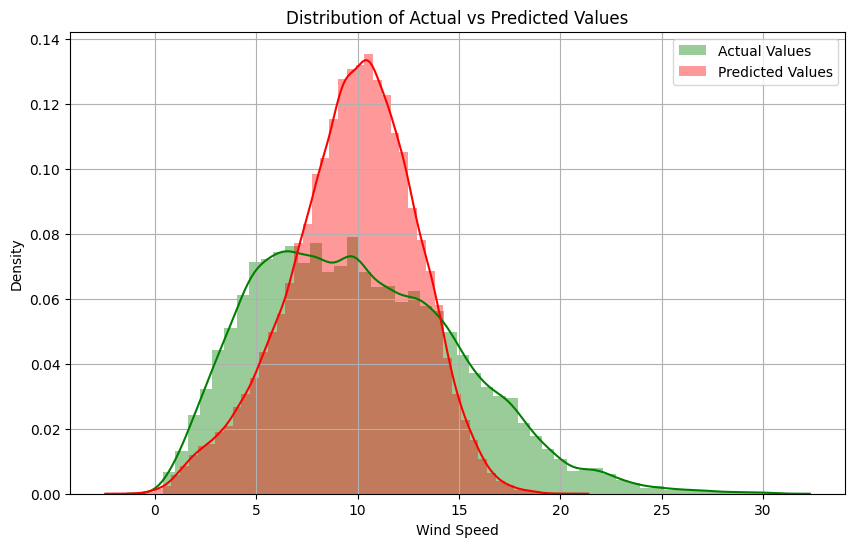

In [33]:
plt.figure(figsize=(10, 6))
#y_test_flat = Y_test.flatten()
y_pred_flat = y_pred.flatten()
y_test_flat = Y_test_inverse.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

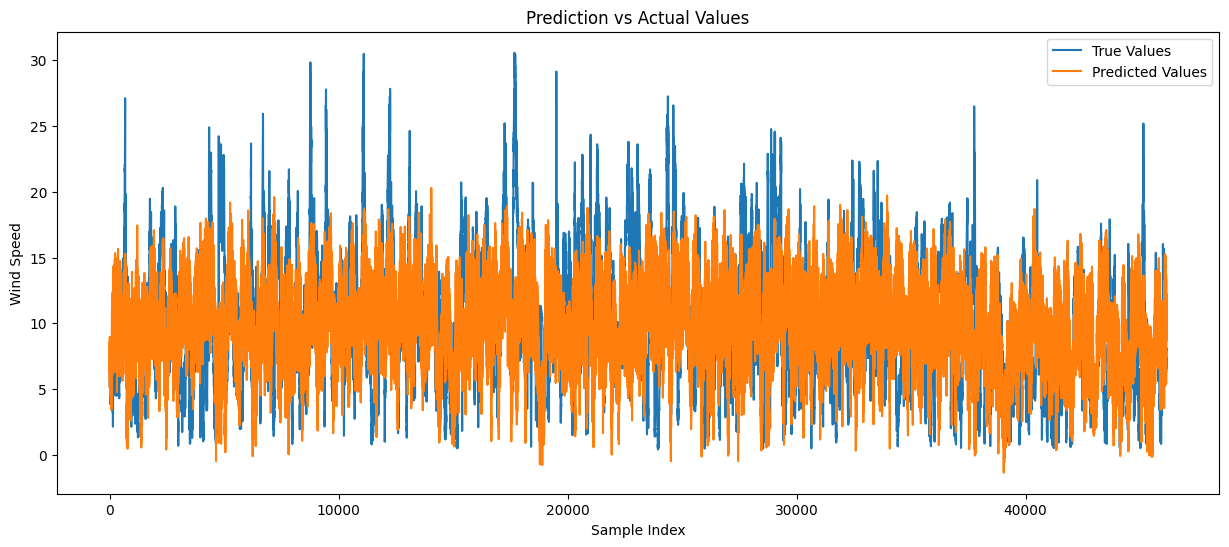

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_flat, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

#### Testing against a new dataset

In [45]:
file_path = "../Data/Wind Time Series Dataset(10min).csv"

new_data = pd.read_csv(file_path)

# Correcting the column name for timestamp and sorting the data
new_data['Time'] = pd.to_datetime(new_data['Time'])

## Extract month, day, hour, and minute
#new_data['month'] = new_data['Time'].dt.month
#new_data['day'] = new_data['Time'].dt.day
#new_data['hour'] = new_data['Time'].dt.hour
#new_data['minute'] = new_data['Time'].dt.minute
#
## Sort the DataFrame by month, day, hour, and minute (ignoring the year)
#sorted_data = new_data.sort_values(by=['month', 'day', 'hour', 'minute'])

new_data.head()  # Display the first few rows of the sorted DataFrame

,Time,WindSpeed,Power
0,2014-10-07 01:20:00,8.22,40.526173
1,2014-10-07 01:30:00,8.09,38.552540
2,2014-10-07 01:50:00,7.21,21.313683
3,2014-10-07 02:00:00,6.75,18.031418
4,2014-10-07 02:10:00,6.52,16.593281


In [46]:
new_wind_speed = new_data["WindSpeed"]

new_wind_speed.head()

0    8.22
1    8.09
2    7.21
3    6.75
4    6.52
Name: WindSpeed, dtype: float64

In [47]:
if len(new_wind_speed.shape) == 1:
    # Reshape the data to be 2D with one column
    new_wind_speed = new_wind_speed.values.reshape(-1, 1)

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(new_wind_speed)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns = ["WindSpeed"])

# Displaying the first few rows of the normalized data
normalized_df.head()

,WindSpeed
0,0.412690
1,0.406091
2,0.361421
3,0.338071
4,0.326396


In [48]:
def create_sequences(data, history_length, forecast_ratio):
    X, Y = [], []
    forecast_length = history_length * forecast_ratio
    total_sequence_length = history_length + forecast_length

    # Check if the total sequence length is longer than the data length
    if total_sequence_length > len(data):
        print("Total sequence length is greater than the data length. Adjusting the lengths.")
        # Adjust the lengths to fit the data
        forecast_length = len(data) - history_length
        total_sequence_length = len(data)

    for i in range(0, len(data) - total_sequence_length + 1, total_sequence_length):
        X.append(data[i:(i + history_length)])
        Y.append(data[(i + history_length):(i + total_sequence_length)])
    return np.array(X), np.array(Y)

X_test, Y_test = create_sequences(normalized_df, input_sequence_length, ratio[1])

# Print shapes to verify
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Total sequence length is greater than the data length. Adjusting the lengths.
X_test shape: (1, 4196, 1)
Y_test shape: (1, 34999, 1)


In [39]:
y_pred = lstm_model.predict(X_test)

1/1 [==============================] - 1s 951ms/step


In [40]:
y_pred = scaler.inverse_transform(y_pred)

num_samples, num_timesteps, num_features = Y_test.shape
Y_test_reshaped = Y_test.reshape(-1, num_features)  # Reshape to 2D
Y_test_inverse = scaler.inverse_transform(Y_test_reshaped)
Y_test_inverse_reshaped = Y_test_inverse.reshape(num_samples, num_timesteps, num_features)

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_15628\921873589.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_15628\921873589.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637

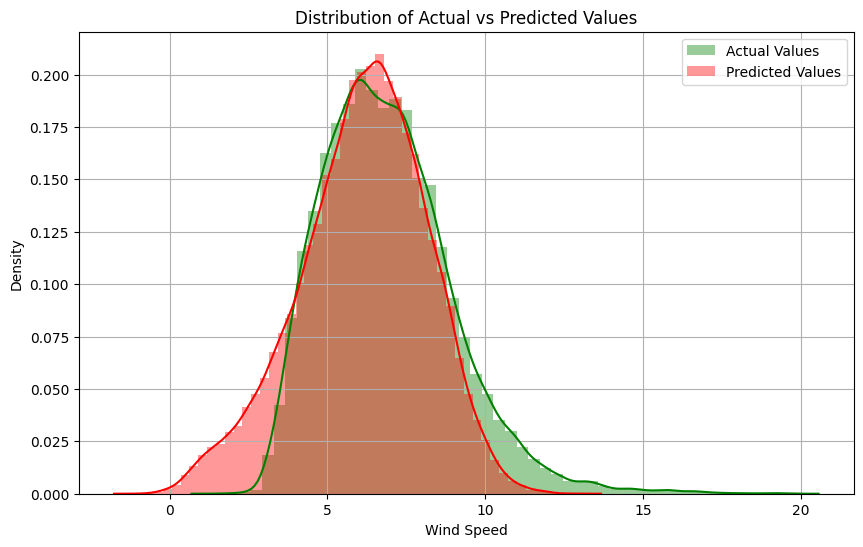

In [41]:
plt.figure(figsize=(10, 6))
#y_test_flat = Y_test.flatten()
y_pred_flat = y_pred.flatten()
y_test_flat = Y_test_inverse.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

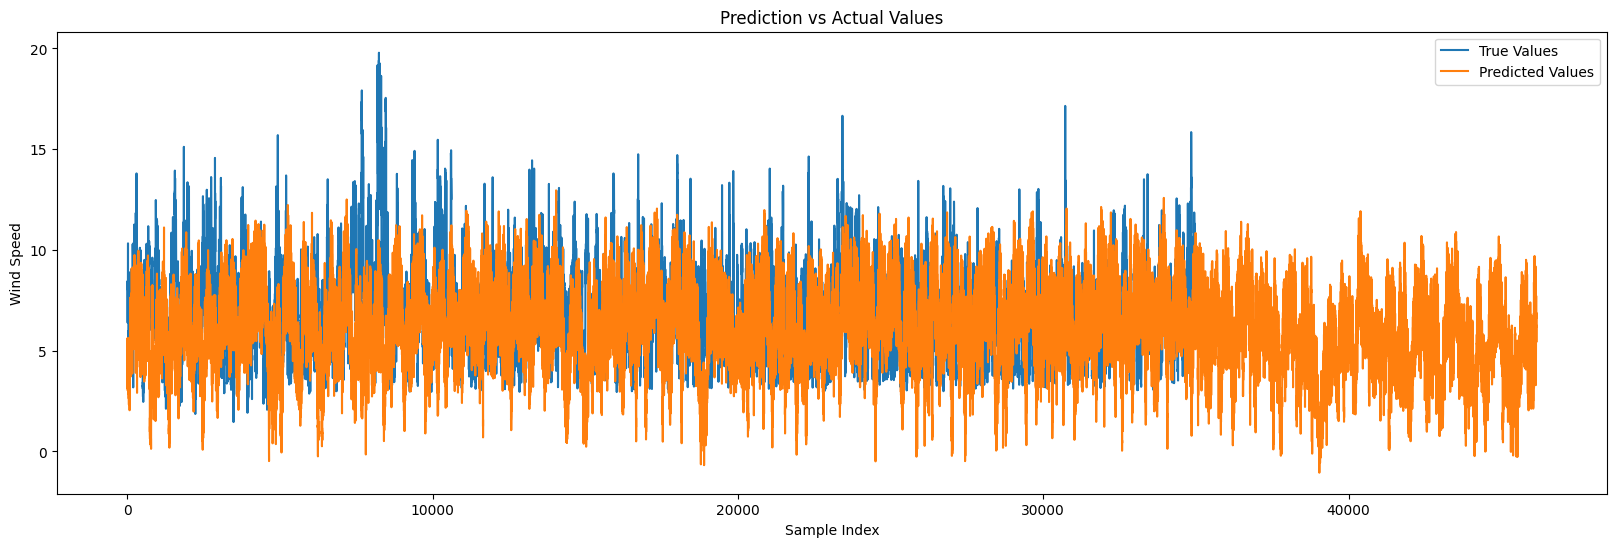

In [42]:
plt.figure(figsize=(20, 6))
plt.plot(y_test_flat, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

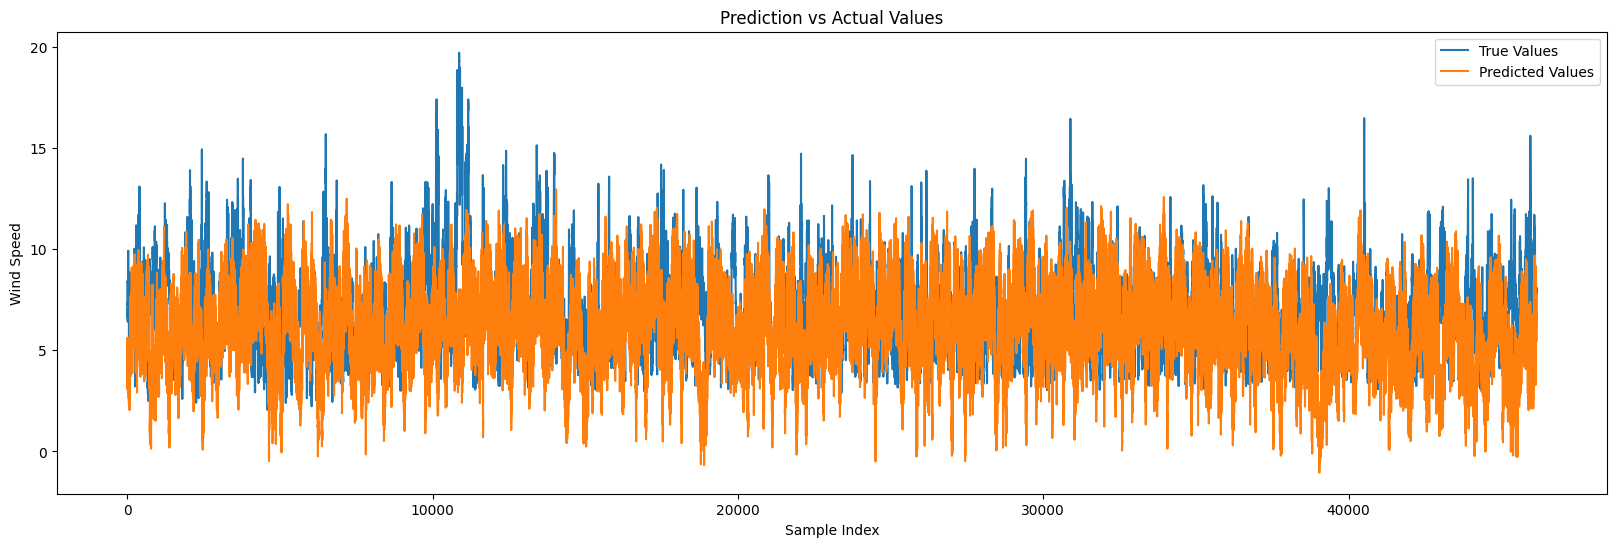

In [43]:
Y_test_interpolated = np.interp(np.linspace(0, 1, len(y_pred_flat)), np.linspace(0, 1, len(y_test_flat)), y_test_flat)
plt.figure(figsize=(20, 6))
plt.plot(Y_test_interpolated, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# Plotting the True Values
ax1.plot(Y_test_interpolated, label='True Values', color='blue')
ax1.set_ylabel('True Wind Speed', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.set_title('True Values')

# Plotting the Predicted Values
ax2.plot(y_pred_flat, label='Predicted Values', color='red')
ax2.set_ylabel('Predicted Wind Speed', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper left')
ax2.set_title('Predicted Values')

# Common X-axis label
plt.xlabel('Sample Index')

plt.show()

#### Different Starting Month

In [51]:
file_path = "../Data/E05_Hudson_South_West_10_min_avg_20220129_20230128.xls"

data = pd.read_excel(file_path)

# Reset the index after sorting
data = data.reset_index(drop=True)

data.head()

,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2022-01-29 00:00:00,10.4512,0.9643,13.4083,8.677,43.9618,0.2045,4,0,32,...,5.316,-7.165,5.282,-7.98,6.971,-6.687,12.97,39.4847,-73.5908,E05
1,2022-01-29 00:10:00,11.0738,0.8861,13.0669,9.1183,43.9564,0.3611,4,0,32,...,5.145,-6.437,5.686,-8.02,8.3,-7.213,12.97,39.4847,-73.5908,E05
2,2022-01-29 00:20:00,11.1295,1.0978,13.8472,8.8772,44.2444,0.2759,4,0,32,...,6.586,-8.72,6.736,-9.23,8.15,-8.99,12.97,39.4847,-73.5909,E05
3,2022-01-29 00:30:00,11.0591,1.0196,13.7819,9.2176,46.5821,0.1763,4,0,33,...,6.492,-7.805,8.22,-8.76,6.353,-8.91,12.97,39.4847,-73.5909,E05
4,2022-01-29 00:40:00,11.1425,0.8374,13.1432,9.2309,49.2058,0.3055,6,0,33,...,6.116,-7.546,6.578,-8.84,8.57,-10.83,12.97,39.4847,-73.5909,E05


In [52]:
# Filtering columns with 'HorizWS' in their names
horiz_ws_columns = [col for col in data.columns if 'lidar_lidar138m_Z10_HorizWS' in col]
horiz_ws_data = data[horiz_ws_columns]

# Converting wind speed columns to numeric, setting errors='coerce' to turn non-numeric values into NaN
numeric_horiz_ws_data = horiz_ws_data.apply(pd.to_numeric, errors='coerce')

# Filtering out all values above 50
cleaned_numeric_horiz_ws_data = numeric_horiz_ws_data[numeric_horiz_ws_data <= 50].dropna()

# Displaying the first few rows of the cleaned numeric data
cleaned_numeric_horiz_ws_data.head()

,lidar_lidar138m_Z10_HorizWS
0,11.5242
1,11.9534
2,11.9038
3,12.4251
4,12.3536


In [53]:
# Initializing the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(cleaned_numeric_horiz_ws_data)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns=cleaned_numeric_horiz_ws_data.columns)

# Displaying the first few rows of the normalized data
normalized_df.head()

,lidar_lidar138m_Z10_HorizWS
0,0.325370
1,0.337943
2,0.336490
3,0.351761
4,0.349666


In [54]:
X_test, Y_test = create_sequences(normalized_df, input_sequence_length, ratio[1])

# Print shapes to verify
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Total sequence length is greater than the data length. Adjusting the lengths.
X_test shape: (1, 4196, 1)
Y_test shape: (1, 44358, 1)


In [55]:
y_pred = lstm_model.predict(X_test)

1/1 [==============================] - 1s 760ms/step


C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_11224\1775046958.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_11224\1775046958.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

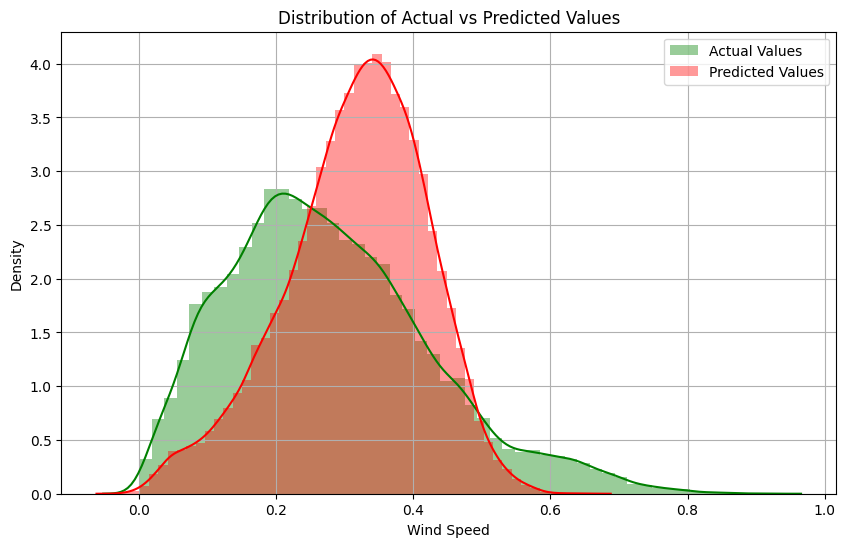

In [56]:
plt.figure(figsize=(10, 6))
#y_test_flat = Y_test.flatten()
y_pred_flat = y_pred.flatten()
y_test_flat = Y_test.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

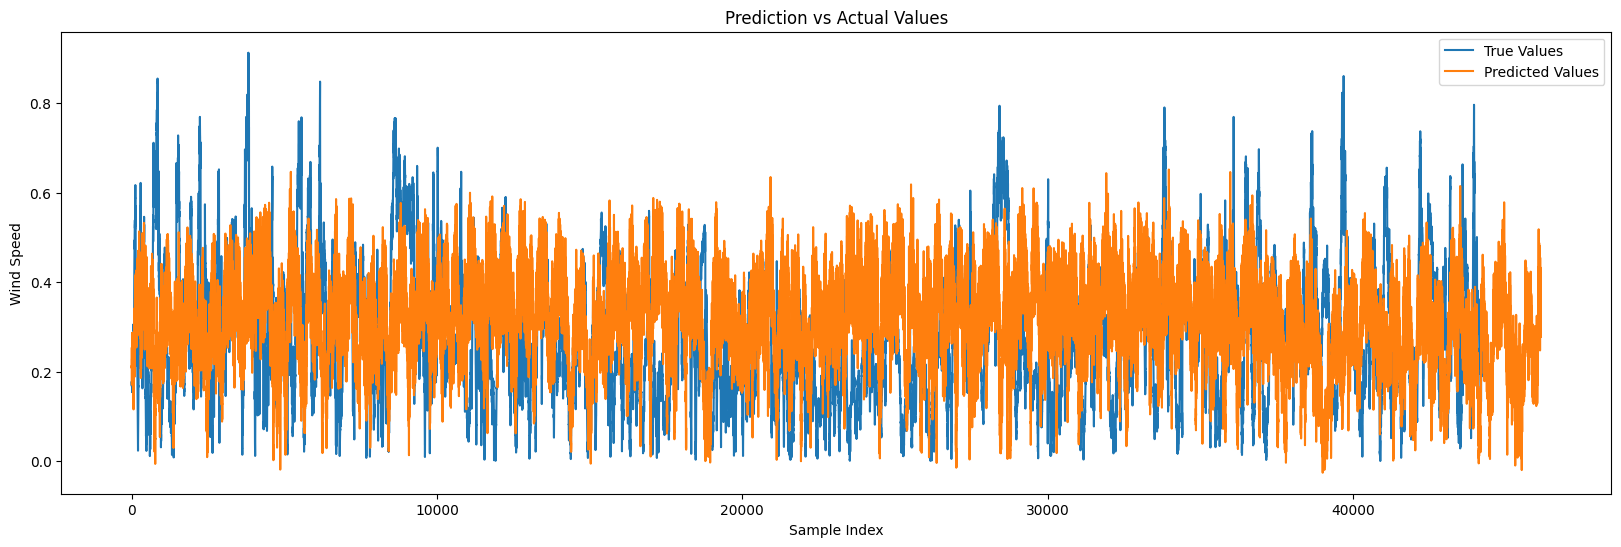

In [57]:
plt.figure(figsize=(20, 6))
plt.plot(y_test_flat, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

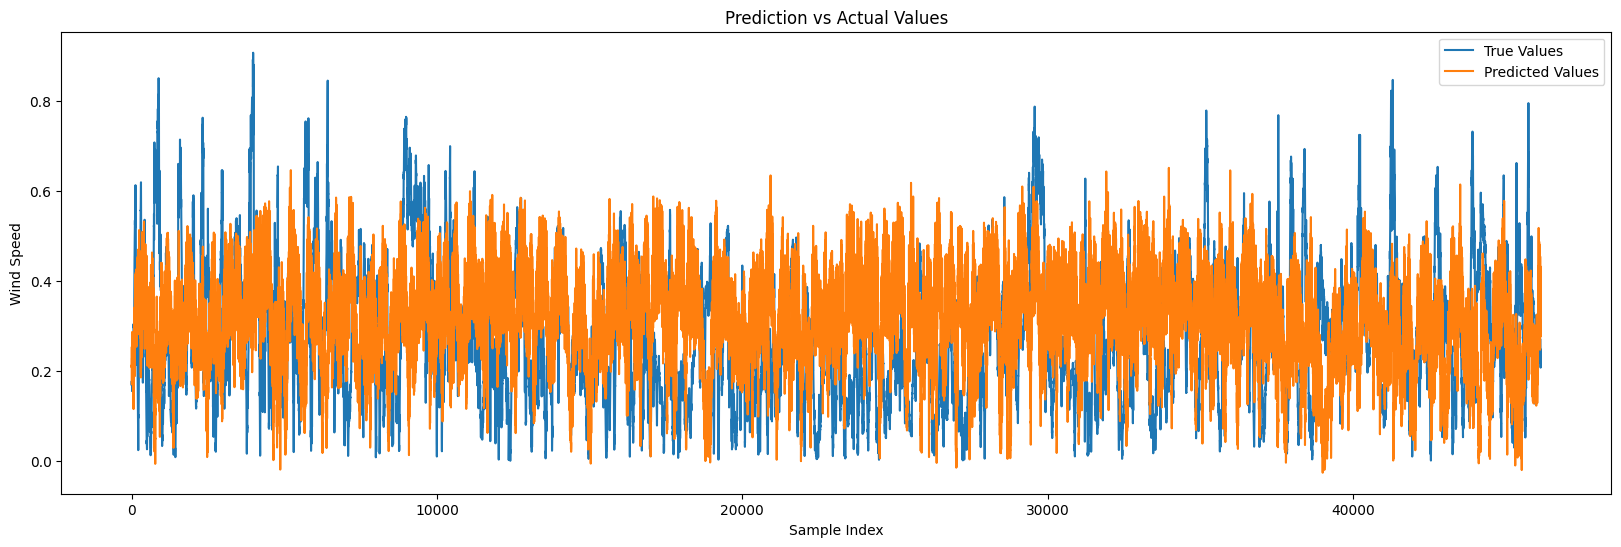

In [64]:
Y_test_interpolated = np.interp(np.linspace(0, 1, len(y_pred_flat)), np.linspace(0, 1, len(y_test_flat)), y_test_flat)
plt.figure(figsize=(20, 6))
plt.plot(Y_test_interpolated, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

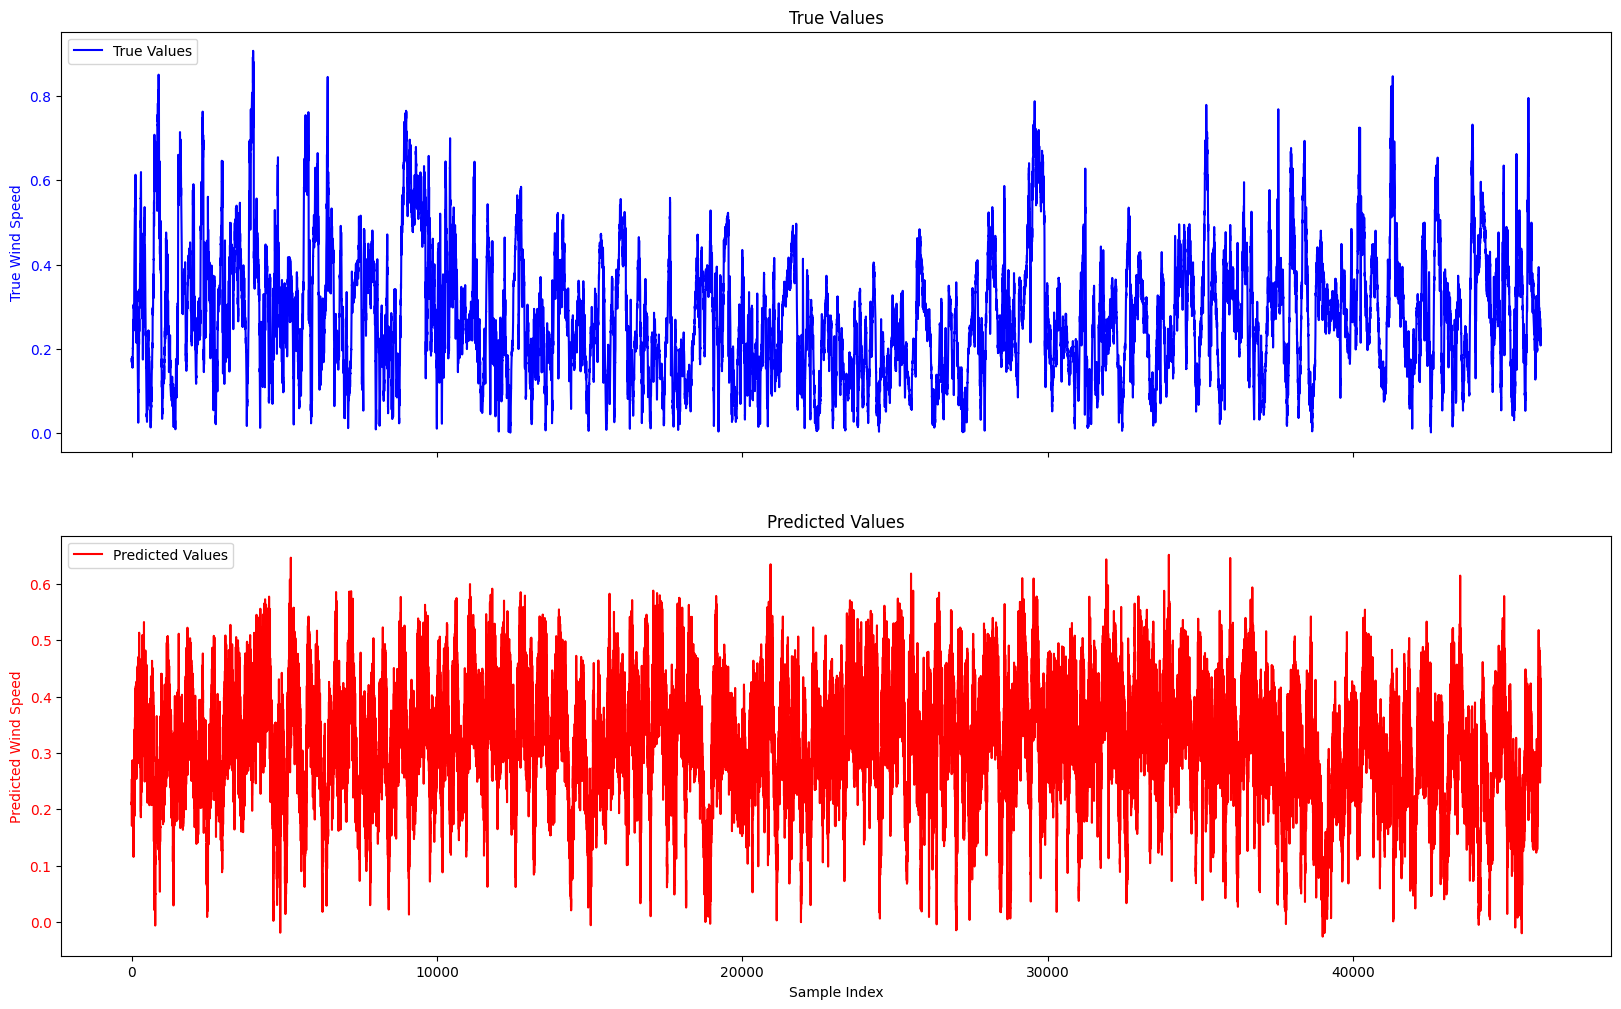

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# Plotting the True Values
ax1.plot(Y_test_interpolated, label='True Values', color='blue')
ax1.set_ylabel('True Wind Speed', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.set_title('True Values')

# Plotting the Predicted Values
ax2.plot(y_pred_flat, label='Predicted Values', color='red')
ax2.set_ylabel('Predicted Wind Speed', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper left')
ax2.set_title('Predicted Values')

# Common X-axis label
plt.xlabel('Sample Index')

plt.show()